In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.unicode_minus'] = False  # prevents minus sign issues
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch

In [2]:
df_patient_info = pd.read_csv('../T1DiabetesGranada/Patient_info.csv', dtype={'Number_of_days_with_measures':np.int32, 'Number_of_measurements':np.int32})
df_glucose_measurements = pd.read_csv('../T1DiabetesGranada/Glucose_measurements.csv', dtype={'Measurement' : np.int16})
df_biochemical_parameters = pd.read_csv('../T1DiabetesGranada/Biochemical_parameters.csv')
df_diagnostics = pd.read_csv('../T1DiabetesGranada/Diagnostics.csv')

In [3]:
df_patient_info.name = 'Patient_info.csv'
df_glucose_measurements.name = 'Glucose_measurements.csv'
df_biochemical_parameters.name = 'Biochemical_parameters.csv'
df_diagnostics.name = 'Diagnostics.csv'

In [4]:
datasets_list = [df_patient_info, df_glucose_measurements, df_biochemical_parameters, df_diagnostics]
datasets_list.reverse()

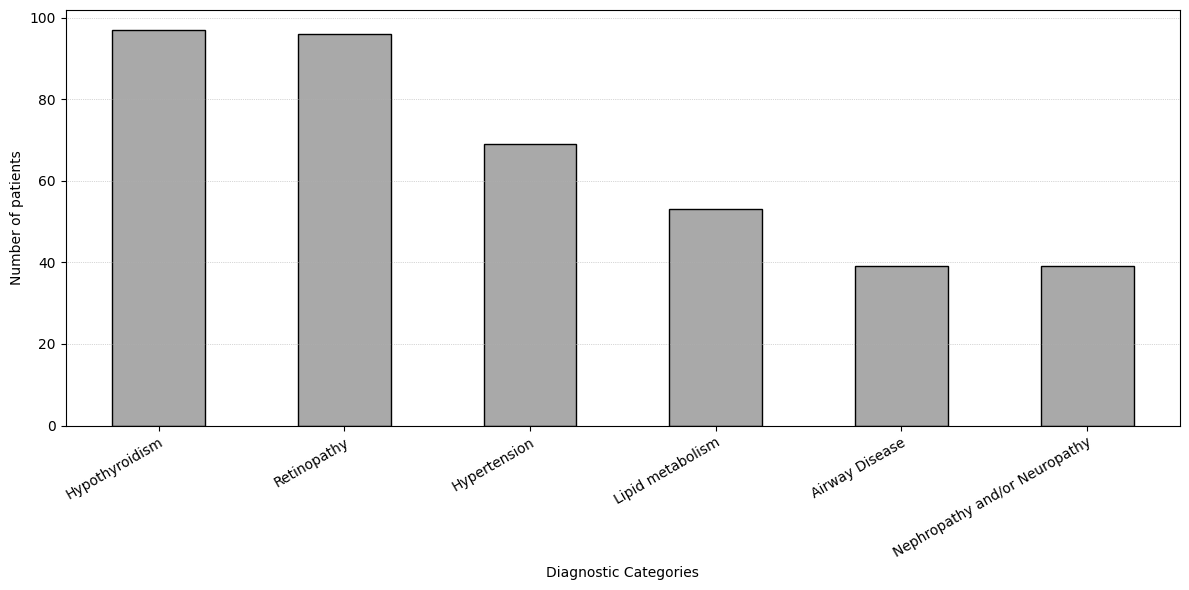

Number of unique patients per category:
Hypothyroidism: 97
Retinopathy: 96
Hypertension: 69
Lipid metabolism: 53
Airway Disease: 39
Nephropathy and/or Neuropathy: 39


In [5]:
category_mapping = {
    'Hypothyroidism': ['244.3', '244.8', '244.9', '244'],
    'Hypertension': ['401', '401.1', '401.9'],
    'Retinopathy': ['250.5', '250.51', '250.53', '362.01', '362.9'],
    'Lipid metabolism': ['272', '272.1', '272.2', '272.4', '272.8'],
    'Airway Disease': ['477', '477.9', '493.9', '493', '493.01', '493.91'],
    'Nephropathy and/or Neuropathy': ['250.4', '250.41','250.6', '250.63']
}

def map_to_category(code):
    code_str = str(code)
    for category, codes in category_mapping.items():
        if code_str in codes:
            return category
    return 'Other'

df_diagnostics['Broad_Category'] = df_diagnostics['Code'].apply(map_to_category)

patient_categories = df_diagnostics.groupby('Patient_ID')['Broad_Category'].unique()

category_counts = {}
for categories in patient_categories:
    for category in categories:
        if category != 'Other':  # Skip 'Other' category
            if category in category_counts:
                category_counts[category] += 1
            else:
                category_counts[category] = 1

category_series = pd.Series(category_counts).sort_values(ascending=False)

ax = category_series.plot(kind='bar', figsize=(12, 6), color='darkgray', edgecolor="black")
ax.grid(axis='y', linestyle=':', linewidth='0.5')

x_labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

max_count = category_series.max()
y_ticks_values = np.arange(0, max_count + 20, 20)
y_ticks_labels = list(map(str, y_ticks_values))
y_ticks = ax.yaxis.set_ticks(y_ticks_values)
y_labels = ax.yaxis.set_ticklabels(y_ticks_labels)

y_title = ax.set_ylabel('Number of patients')
x_title = ax.set_xlabel('Diagnostic Categories')

plt.tight_layout()
plt.show()

print("Number of unique patients per category:")
for category, count in category_series.items():
    print(f"{category}: {count}")

In [6]:
LOW = 70
HIGH = 180

def compute_cgm_features_rich_vectorized(group, n_segments=4, conga_lag=4, spike_threshold=50):
    values = group['Measurement'].values
    timestamps = (group['Timestamp'] - group['Timestamp'].min()).dt.total_seconds().values
    n = len(values)
    if n < 2:
        return pd.Series({'Patient_ID': group['Patient_ID'].iloc[0]})
    
    # --- Temporal segmentation ---
    segment_size = n // n_segments
    segments = [values[i*segment_size: n if i==n_segments-1 else (i+1)*segment_size] for i in range(n_segments)]
    TIR_Q = [np.mean((s >= LOW) & (s <= HIGH)) * 100 for s in segments]
    TBR_Q = [np.mean(s < LOW) * 100 for s in segments]
    CV_Q  = [np.std(s)/np.mean(s) if np.mean(s)!=0 else 0 for s in segments]

    # --- Trend features ---
    tir_array = ((values >= LOW) & (values <= HIGH)).astype(int)
    slope_tir = linregress(timestamps, tir_array).slope * 86400
    slope_mean = linregress(timestamps, values).slope * 86400

    # --- Distributional percentiles ---
    percentiles = np.percentile(values, [10,25,50,75,90])
    dist_features = {f'glucose_p{p}': val for p,val in zip([10,25,50,75,90], percentiles)}

    # --- Rolling statistics ---
    rolling_window = max(2, n//10)
    roll_series = pd.Series(values)
    rolling_std = roll_series.rolling(rolling_window).std().to_numpy()
    rolling_mean = roll_series.rolling(rolling_window).mean().to_numpy()
    rolling_cv = rolling_std / np.where(rolling_mean!=0, rolling_mean, np.nan)
    rolling_features = {'rolling_mean_std': np.nanstd(rolling_std),
                        'rolling_cv_std': np.nanstd(rolling_cv)}

    # --- Glycemic variability metrics ---
    diffs = np.diff(values)
    mage = np.mean(np.abs(diffs)[np.abs(diffs) > np.std(values)]) if len(diffs)>0 else 0
    modd = np.mean(np.abs(diffs)) if len(diffs)>0 else 0
    conga = np.std(values[conga_lag:] - values[:-conga_lag]) if n > conga_lag else 0
    gly_var_features = {'MAGE': mage, 'MODD': modd, f'CONGA_{conga_lag}': conga}

    # --- Hypo/Hyper events ---
    hypo = (values < LOW).astype(int)
    hyper = (values > HIGH).astype(int)
    hypo_count = np.sum((np.diff(np.concatenate([[0], hypo, [0]]))==1))
    hyper_count = np.sum((np.diff(np.concatenate([[0], hyper, [0]]))==1))
    hypo_durations = np.diff(np.where(np.concatenate([[0], hypo, [0]])==1)[0])[::2]
    hyper_durations = np.diff(np.where(np.concatenate([[0], hyper, [0]])==1)[0])[::2]
    event_features = {'hypo_count': hypo_count, 'hyper_count': hyper_count,
                      'avg_hypo_duration': np.mean(hypo_durations) if len(hypo_durations)>0 else 0,
                      'avg_hyper_duration': np.mean(hyper_durations) if len(hyper_durations)>0 else 0}

    # --- Time-of-day features ---
    hours = group['Timestamp'].dt.hour.values
    day_mask = (hours >=6) & (hours<22)
    night_mask = ~day_mask
    day_values = values[day_mask]
    night_values = values[night_mask]
    time_features = {
        'TIR_day': np.mean((day_values>=LOW) & (day_values<=HIGH))*100 if len(day_values)>0 else np.nan,
        'TIR_night': np.mean((night_values>=LOW) & (night_values<=HIGH))*100 if len(night_values)>0 else np.nan,
        'TBR_day': np.mean(day_values<LOW)*100 if len(day_values)>0 else np.nan,
        'TBR_night': np.mean(night_values<LOW)*100 if len(night_values)>0 else np.nan,
        'CV_day': np.std(day_values)/np.mean(day_values) if len(day_values)>0 and np.mean(day_values)!=0 else 0,
        'CV_night': np.std(night_values)/np.mean(night_values) if len(night_values)>0 and np.mean(night_values)!=0 else 0
    }

    # --- Spike/fall frequency ---
    spike_count = np.sum(np.abs(diffs) > spike_threshold)
    spike_features = {'rapid_spike_count': spike_count}

    # --- Interaction features ---
    interaction_features = {'slope_CV_interaction': slope_mean * np.nanmean(list(TIR_Q+TBR_Q+CV_Q))}

    # --- Combine all features ---
    all_features = {'Patient_ID': group['Patient_ID'].iloc[0],
                    **{f'TIR_Q{i+1}': TIR_Q[i] for i in range(n_segments)},
                    **{f'TBR_Q{i+1}': TBR_Q[i] for i in range(n_segments)},
                    **{f'CV_Q{i+1}': CV_Q[i] for i in range(n_segments)},
                    'slope_TIR_per_day': slope_tir,
                    'slope_mean_glucose_per_day': slope_mean,
                    **dist_features,
                    **rolling_features,
                    **gly_var_features,
                    **event_features,
                    **time_features,
                    **spike_features,
                    **interaction_features}
    
    return pd.Series(all_features)


# =====================
# Parallelized application
# =====================
def compute_all_cgm_features_vectorized(df_glucose, n_jobs=-1):
    df_glucose['Timestamp'] = pd.to_datetime(df_glucose['Measurement_date'] + ' ' + df_glucose['Measurement_time'])
    df_glucose = df_glucose.sort_values(['Patient_ID','Timestamp'])
    patients = [group for _, group in df_glucose.groupby('Patient_ID')]
    results = Parallel(n_jobs=n_jobs)(delayed(compute_cgm_features_rich_vectorized)(p) for p in patients)
    return pd.DataFrame(results)


# Usage
df_metrics = compute_all_cgm_features_vectorized(df_glucose_measurements)

In [7]:
# Temporarily display all columns and widen display
with pd.option_context('display.max_columns', None, 'display.width', 200):
    print(df_metrics.head())

  Patient_ID     TIR_Q1     TIR_Q2     TIR_Q3     TIR_Q4     TBR_Q1     TBR_Q2     TBR_Q3     TBR_Q4     CV_Q1     CV_Q2     CV_Q3     CV_Q4  slope_TIR_per_day  slope_mean_glucose_per_day  \
0  LIB193263  52.442758  50.818690  52.822151  54.186077   2.496006   1.783813   1.517572   1.969919  0.360504  0.348099  0.330821  0.369508           0.000078                   -0.008867   
1  LIB193264  60.707885  64.799881  63.246714  61.143454   3.539427   7.840502   9.692354  11.061352  0.374041  0.425312  0.416344  0.449794           0.000039                   -0.044483   
2  LIB193265  57.772243  68.258330  61.645483  70.173480  13.122638  18.275507  16.360357  14.900378  0.597998  0.441977  0.475675  0.435655           0.000240                   -0.063293   
3  LIB193266  66.138714  70.702249  64.135387  73.450495   1.034208   1.337962   2.198597   2.241990  0.346719  0.368783  0.354826  0.363463           0.000119                   -0.019502   
4  LIB193267  61.736937  51.236036  50.234234

In [8]:
def multicollinearity_diagnostics(df_features, vif_threshold=10):
    X = df_features.drop(columns=['Patient_ID'], errors='ignore')
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    vif_df = pd.DataFrame({
        'feature': X.columns,
        'VIF': [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    }).sort_values('VIF', ascending=False)
    corr_matrix = np.corrcoef(X_scaled, rowvar=False)
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    condition_number = np.sqrt(eigenvalues.max() / eigenvalues.min())
    diagnostics = {
        'vif_table': vif_df,
        'max_vif': vif_df['VIF'].max(),
        'n_high_vif': (vif_df['VIF'] > vif_threshold).sum(),
        'condition_number': condition_number,
        'min_eigenvalue': eigenvalues.min()
    }
    return diagnostics

diagnostics = multicollinearity_diagnostics(df_metrics)
diagnostics['vif_table'].head(15)

,feature,VIF
27,TIR_day,1928.526325
29,TBR_day,1277.882796
28,TIR_night,506.425683
30,TBR_night,444.731907
3,TIR_Q4,325.773130
2,TIR_Q3,319.367079
17,glucose_p75,305.408881
1,TIR_Q2,295.987829
4,TBR_Q1,278.287846
16,glucose_p50,268.696054


In [9]:
# Filter only A1c measurements
df_a1c = df_biochemical_parameters[df_biochemical_parameters['Name'] == 'Glycated hemoglobin (A1c)']

# Compute mean and SD per patient
df_a1c_metrics = df_a1c.groupby('Patient_ID')['Value'].agg(
    A1c_mean='mean',
    A1c_SD='std'
).reset_index()

# Merge into existing df_metrics
df_metrics = df_metrics.merge(df_a1c_metrics, on='Patient_ID', how='left')

In [10]:
df_metrics.head()

,Patient_ID,TIR_Q1,TIR_Q2,TIR_Q3,TIR_Q4,TBR_Q1,TBR_Q2,TBR_Q3,TBR_Q4,CV_Q1,...,TIR_day,TIR_night,TBR_day,TBR_night,CV_day,CV_night,rapid_spike_count,slope_CV_interaction,A1c_mean,A1c_SD
0,LIB193263,52.442758,50.818690,52.822151,54.186077,2.496006,1.783813,1.517572,1.969919,0.360504,...,53.208027,51.201459,1.869821,2.095387,0.358668,0.339263,99,-0.162158,NaN,NaN
1,LIB193264,60.707885,64.799881,63.246714,61.143454,3.539427,7.840502,9.692354,11.061352,0.374041,...,63.582764,60.145850,8.755786,6.516958,0.421392,0.407861,110,-1.051631,NaN,NaN
2,LIB193265,57.772243,68.258330,61.645483,70.173480,13.122638,18.275507,16.360357,14.900378,0.597998,...,63.475177,66.725576,14.088807,19.277534,0.516363,0.514277,283,-1.700777,7.616667,0.617792
3,LIB193266,66.138714,70.702249,64.135387,73.450495,1.034208,1.337962,2.198597,2.241990,0.346719,...,69.027682,67.595497,1.400732,2.429723,0.353458,0.375099,1797,-0.459395,8.640000,4.022188
4,LIB193267,61.736937,51.236036,50.234234,45.611127,1.232432,1.636036,2.003604,1.498991,0.351561,...,53.075966,50.344477,1.124547,2.592049,0.364411,0.409560,512,0.907573,8.025000,0.433013


In [11]:
# Study baseline year is 2018
STUDY_YEAR = 2018

# Select only the relevant columns from df_patient_info
demographics = df_patient_info[['Patient_ID', 
                                'Sex', 
                                'Birth_year', 
                                'Number_of_days_with_measures', 
                                'Number_of_measurements', 
                                'Number_of_biochemical_parameters', 
                                'Number_of_diagnostics']].drop_duplicates(subset='Patient_ID')

# Compute Age at study baseline
demographics['Age'] = STUDY_YEAR - demographics['Birth_year']

# Drop Birth_year if you only want Age
demographics = demographics.drop(columns=['Birth_year'])

# Merge into df_metrics
df_metrics = df_metrics.merge(demographics, on='Patient_ID', how='left')

In [12]:
df_metrics.head()

,Patient_ID,TIR_Q1,TIR_Q2,TIR_Q3,TIR_Q4,TBR_Q1,TBR_Q2,TBR_Q3,TBR_Q4,CV_Q1,...,rapid_spike_count,slope_CV_interaction,A1c_mean,A1c_SD,Sex,Number_of_days_with_measures,Number_of_measurements,Number_of_biochemical_parameters,Number_of_diagnostics,Age
0,LIB193263,52.442758,50.818690,52.822151,54.186077,2.496006,1.783813,1.517572,1.969919,0.360504,...,99,-0.162158,NaN,NaN,M,648,60097,NaN,1.0,53
1,LIB193264,60.707885,64.799881,63.246714,61.143454,3.539427,7.840502,9.692354,11.061352,0.374041,...,110,-1.051631,NaN,NaN,F,326,26786,NaN,3.0,43
2,LIB193265,57.772243,68.258330,61.645483,70.173480,13.122638,18.275507,16.360357,14.900378,0.597998,...,283,-1.700777,7.616667,0.617792,F,581,46575,120.0,NaN,38
3,LIB193266,66.138714,70.702249,64.135387,73.450495,1.034208,1.337962,2.198597,2.241990,0.346719,...,1797,-0.459395,8.640000,4.022188,M,500,55307,74.0,2.0,20
4,LIB193267,61.736937,51.236036,50.234234,45.611127,1.232432,1.636036,2.003604,1.498991,0.351561,...,512,0.907573,8.025000,0.433013,F,647,55500,177.0,1.0,38


In [13]:
# List of biochemical parameters of interest
parameters_of_interest = [
    'Alanine transaminase (GPT)',
    'Albumin (urine)',
    'Chlorine',
    'Creatinine',
    'Creatinine (urine)',
    'Gamma-glutamyl Transferase (GGT)',
    'Glucose',
    'HDL cholesterol',
    'Potassium',
    'Sodium',
    'Thyrotropin (TSH)',
    'Total cholesterol',
    'Triglycerides',
    'Uric acid'
]

# Filter the dataframe to keep only these parameters
df_biochem_filtered = df_biochemical_parameters[
    df_biochemical_parameters['Name'].isin(parameters_of_interest)
]

# Compute mean per patient for each parameter
df_biochem_means = df_biochem_filtered.groupby(['Patient_ID', 'Name'])['Value'].mean().unstack()

# Optional: rename columns to indicate they are means
df_biochem_means = df_biochem_means.add_suffix('_mean').reset_index()

# Merge into df_metrics
df_metrics = df_metrics.merge(df_biochem_means, on='Patient_ID', how='left')

In [14]:
df_metrics.head()

,Patient_ID,TIR_Q1,TIR_Q2,TIR_Q3,TIR_Q4,TBR_Q1,TBR_Q2,TBR_Q3,TBR_Q4,CV_Q1,...,Creatinine (urine)_mean,Gamma-glutamyl Transferase (GGT)_mean,Glucose_mean,HDL cholesterol_mean,Potassium_mean,Sodium_mean,Thyrotropin (TSH)_mean,Total cholesterol_mean,Triglycerides_mean,Uric acid_mean
0,LIB193263,52.442758,50.818690,52.822151,54.186077,2.496006,1.783813,1.517572,1.969919,0.360504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIB193264,60.707885,64.799881,63.246714,61.143454,3.539427,7.840502,9.692354,11.061352,0.374041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIB193265,57.772243,68.258330,61.645483,70.173480,13.122638,18.275507,16.360357,14.900378,0.597998,...,140.260000,10.200000,186.900000,73.857143,4.260000,136.400000,4.173250,205.250000,94.375000,4.288889
3,LIB193266,66.138714,70.702249,64.135387,73.450495,1.034208,1.337962,2.198597,2.241990,0.346719,...,146.402500,15.500000,157.571429,49.200000,3.751429,139.428571,1.539750,153.000000,63.200000,4.800000
4,LIB193267,61.736937,51.236036,50.234234,45.611127,1.232432,1.636036,2.003604,1.498991,0.351561,...,117.282727,19.583333,172.071429,56.916667,4.678667,138.600000,2.692364,180.583333,75.166667,3.763636


In [15]:
# List of the base (fine-grained) categories
categories = list(category_mapping.keys())

# Create a DataFrame where each row is a patient, each column is a category
df_diag_binary = pd.DataFrame(
    0,
    index=df_metrics['Patient_ID'],
    columns=categories
)
df_diag_binary.index.name = 'Patient_ID'
df_diag_binary = df_diag_binary.reset_index()

# Fill in 1s where patients have the category
for patient_id, cat_list in patient_categories.items():
    for cat in cat_list:
        if cat in categories:
            df_diag_binary.loc[
                df_diag_binary['Patient_ID'] == patient_id, cat
            ] = 1

# Merge the binary columns into df_metrics
df_metrics = df_metrics.merge(
    df_diag_binary,
    on='Patient_ID',
    how='left'
)

In [16]:
df_metrics.head()

,Patient_ID,TIR_Q1,TIR_Q2,TIR_Q3,TIR_Q4,TBR_Q1,TBR_Q2,TBR_Q3,TBR_Q4,CV_Q1,...,Thyrotropin (TSH)_mean,Total cholesterol_mean,Triglycerides_mean,Uric acid_mean,Hypothyroidism,Hypertension,Retinopathy,Lipid metabolism,Airway Disease,Nephropathy and/or Neuropathy
0,LIB193263,52.442758,50.818690,52.822151,54.186077,2.496006,1.783813,1.517572,1.969919,0.360504,...,NaN,NaN,NaN,NaN,0,0,0,1,0,0
1,LIB193264,60.707885,64.799881,63.246714,61.143454,3.539427,7.840502,9.692354,11.061352,0.374041,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,LIB193265,57.772243,68.258330,61.645483,70.173480,13.122638,18.275507,16.360357,14.900378,0.597998,...,4.173250,205.250000,94.375000,4.288889,0,0,0,0,0,0
3,LIB193266,66.138714,70.702249,64.135387,73.450495,1.034208,1.337962,2.198597,2.241990,0.346719,...,1.539750,153.000000,63.200000,4.800000,0,0,0,0,0,0
4,LIB193267,61.736937,51.236036,50.234234,45.611127,1.232432,1.636036,2.003604,1.498991,0.351561,...,2.692364,180.583333,75.166667,3.763636,0,0,0,0,0,0


In [17]:
pd.set_option('display.max_columns', None)
print(df_metrics.describe(include='all'))

       Patient_ID      TIR_Q1      TIR_Q2      TIR_Q3      TIR_Q4      TBR_Q1  \
count         736  736.000000  736.000000  736.000000  736.000000  736.000000   
unique        736         NaN         NaN         NaN         NaN         NaN   
top     LIB194120         NaN         NaN         NaN         NaN         NaN   
freq            1         NaN         NaN         NaN         NaN         NaN   
mean          NaN   59.525814   58.850762   58.124696   57.523446    4.981615   
std           NaN   15.848966   16.509553   17.160004   17.421092    5.070263   
min           NaN    1.698514    1.875442    3.821656    0.656455    0.000000   
25%           NaN   48.774207   48.048042   46.532949   46.046292    1.416030   
50%           NaN   60.322566   59.665598   59.330291   58.402957    3.546801   
75%           NaN   70.054095   70.203259   70.106176   69.763557    7.320738   
max           NaN   98.307432   98.584398   98.257081   97.077391   45.528455   

            TBR_Q2      TBR

In [18]:
# Save df_metrics to CSV in the current working directory
df_metrics.to_csv('df_metrics_CGM_biochem_demographics.csv', index=False)

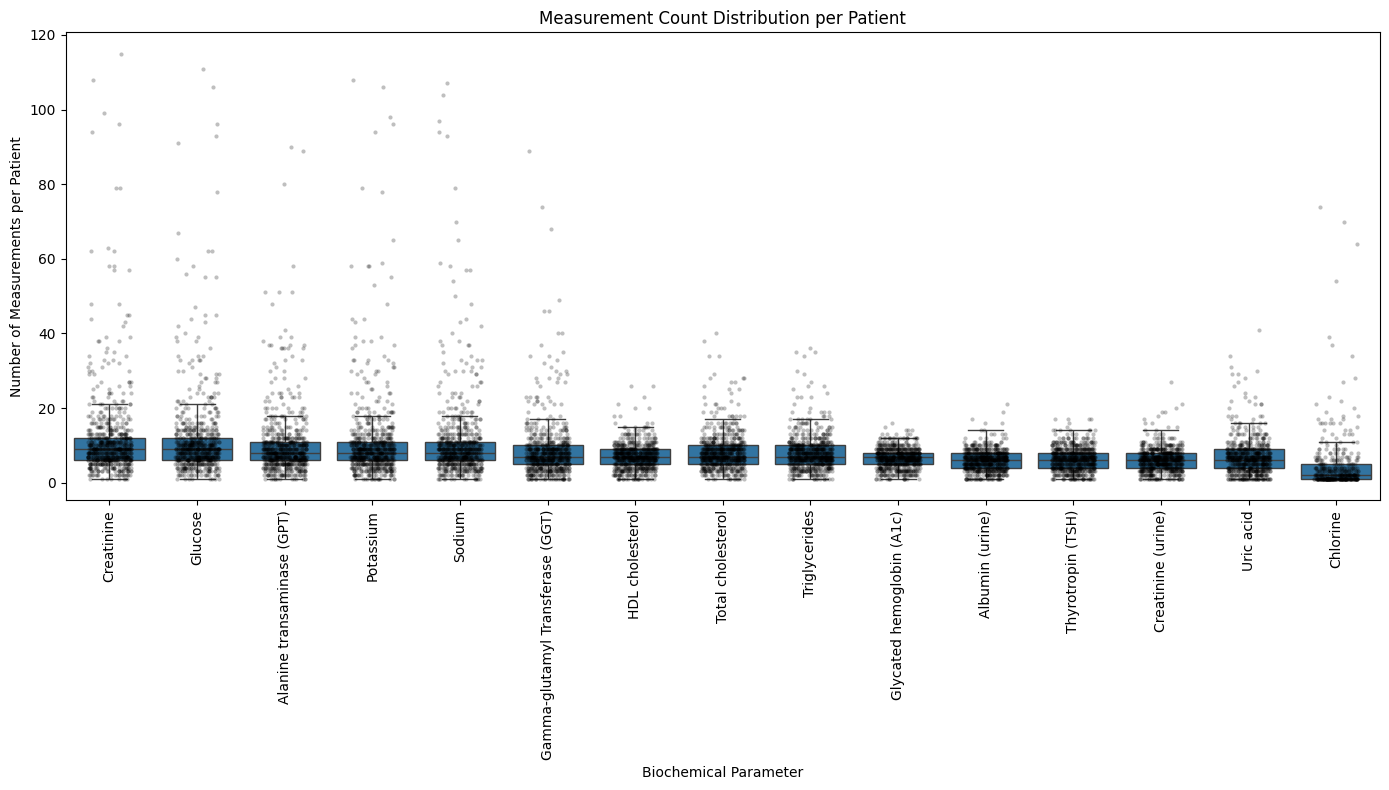

In [22]:
counts = (
    df_biochemical_parameters
    .groupby(['Name', 'Patient_ID'])
    .size()
    .reset_index(name='n_measurements')
)

exclude = ['IA2 ANTIBODIES', 'Insulin']
counts = counts[~counts['Name'].isin(exclude)]

order = (
    counts.groupby('Name')['n_measurements']
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(14, 8))

sns.boxplot(
    data=counts,
    x='Name',
    y='n_measurements',
    order=order,
    showfliers=False   # remove extreme outlier dots (we'll show real points instead)
)

sns.stripplot(
    data=counts,
    x='Name',
    y='n_measurements',
    order=order,
    color='black',
    alpha=0.25,        # transparency so overlap shows density
    jitter=0.25,
    size=3
)

plt.xticks(rotation=90)
plt.ylabel('Number of Measurements per Patient')
plt.xlabel('Biochemical Parameter')
plt.title('Measurement Count Distribution per Patient')

plt.tight_layout()
plt.show()

In [23]:
demographic_cols = ['Sex',	'Number_of_days_with_measures',	'Number_of_measurements',	'Number_of_biochemical_parameters',	'Number_of_diagnostics',	'Age']

biochemical_cols = ['Alanine transaminase (GPT)_mean',	'Albumin (urine)_mean',	'Chlorine_mean',	'Creatinine_mean',	'Creatinine (urine)_mean',	'Gamma-glutamyl Transferase (GGT)_mean',	
                    'Glucose_mean',	'HDL cholesterol_mean',	'Potassium_mean',	'Sodium_mean',	'Thyrotropin (TSH)_mean',	'Total cholesterol_mean',	'Triglycerides_mean',	'Uric acid_mean',
                    'A1c_mean',	'A1c_SD']

cgm_cols = [
'TIR_Q1',	'TIR_Q2',	'TIR_Q3',	'TIR_Q4',	'TBR_Q1',	'TBR_Q2',	'TBR_Q3',	'TBR_Q4',	'CV_Q1',	'CV_Q2',	'CV_Q3',	'CV_Q4',	'slope_TIR_per_day',	'slope_mean_glucose_per_day',	
    'glucose_p10',	'glucose_p25',	'glucose_p50',	'glucose_p75',	'glucose_p90',	'rolling_mean_std',	'rolling_cv_std',	'MAGE',	'MODD',	'CONGA_4',	'hypo_count',	'hyper_count',	
    'avg_hypo_duration',	'avg_hyper_duration',	'TIR_day',	'TIR_night',	'TBR_day',	'TBR_night',	'CV_day',	'CV_night',	'rapid_spike_count',	'slope_CV_interaction']

response_cols = ['Hypothyroidism',	'Hypertension',	'Retinopathy',	'Lipid metabolism',	'Airway Disease',	'Nephropathy and/or Neuropathy']

In [30]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

df = df_metrics.copy()

df = df.drop(columns=['Patient_ID'])

summary_rows = []

for col in df.columns:
    
    if col in demographic_cols:
        group = "Demographic"
    elif col in biochemical_cols:
        group = "Biochemical"
    elif col in cgm_cols:
        group = "CGM"
    elif col in response_cols:
        group = "Response"
    else:
        group = "Other"
    
    # Missing percentage
    missing_pct = df[col].isna().mean() * 100
    
    # Determine variable type
    if pd.api.types.is_numeric_dtype(df[col]):
        
        unique_vals = df[col].dropna().unique()
        
        # Detect binary
        if len(unique_vals) <= 2:
            var_type = "Binary"
            counts = df[col].value_counts(dropna=True)
            summary_stat = "; ".join(
                [f"{k}: {v} ({v/len(df)*100:.1f}%)" for k, v in counts.items()]
            )
        else:
            var_type = "Continuous"
            median = df[col].median()
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            summary_stat = f"{median:.2f} ({q1:.2f}–{q3:.2f})"
    
    else:
        var_type = "Categorical"
        counts = df[col].value_counts(dropna=True)
        summary_stat = "; ".join(
            [f"{k}: {v} ({v/len(df)*100:.1f}%)" for k, v in counts.items()]
        )
    
    summary_rows.append({
        "Feature": col,
        "Group": group,
        "Type": var_type,
        "Missing (%)": round(missing_pct, 2),
        "Summary": summary_stat
    })

supp_table = pd.DataFrame(summary_rows)

supp_table["Definition"] = "."
cols = list(supp_table.columns)
cols = [c for c in cols if c != "Definition"] + ["Definition"]
supp_table = supp_table[cols]

supp_table = supp_table.sort_values(["Group"])

print(supp_table.to_string(index=False))

                              Feature       Group        Type  Missing (%)                        Summary Definition
                        Chlorine_mean Biochemical  Continuous        42.53         103.00 (101.00–104.80)          .
                             A1c_mean Biochemical  Continuous         2.17               7.75 (7.11–8.51)          .
                               A1c_SD Biochemical  Continuous         4.08               0.55 (0.37–0.85)          .
      Alanine transaminase (GPT)_mean Biochemical  Continuous         1.90            19.52 (15.00–26.17)          .
                 Albumin (urine)_mean Biochemical  Continuous         3.12               0.85 (0.70–1.46)          .
                      Creatinine_mean Biochemical  Continuous         1.77               0.78 (0.68–0.92)          .
              Creatinine (urine)_mean Biochemical  Continuous         3.12          113.40 (77.56–153.46)          .
                         Glucose_mean Biochemical  Continuous   

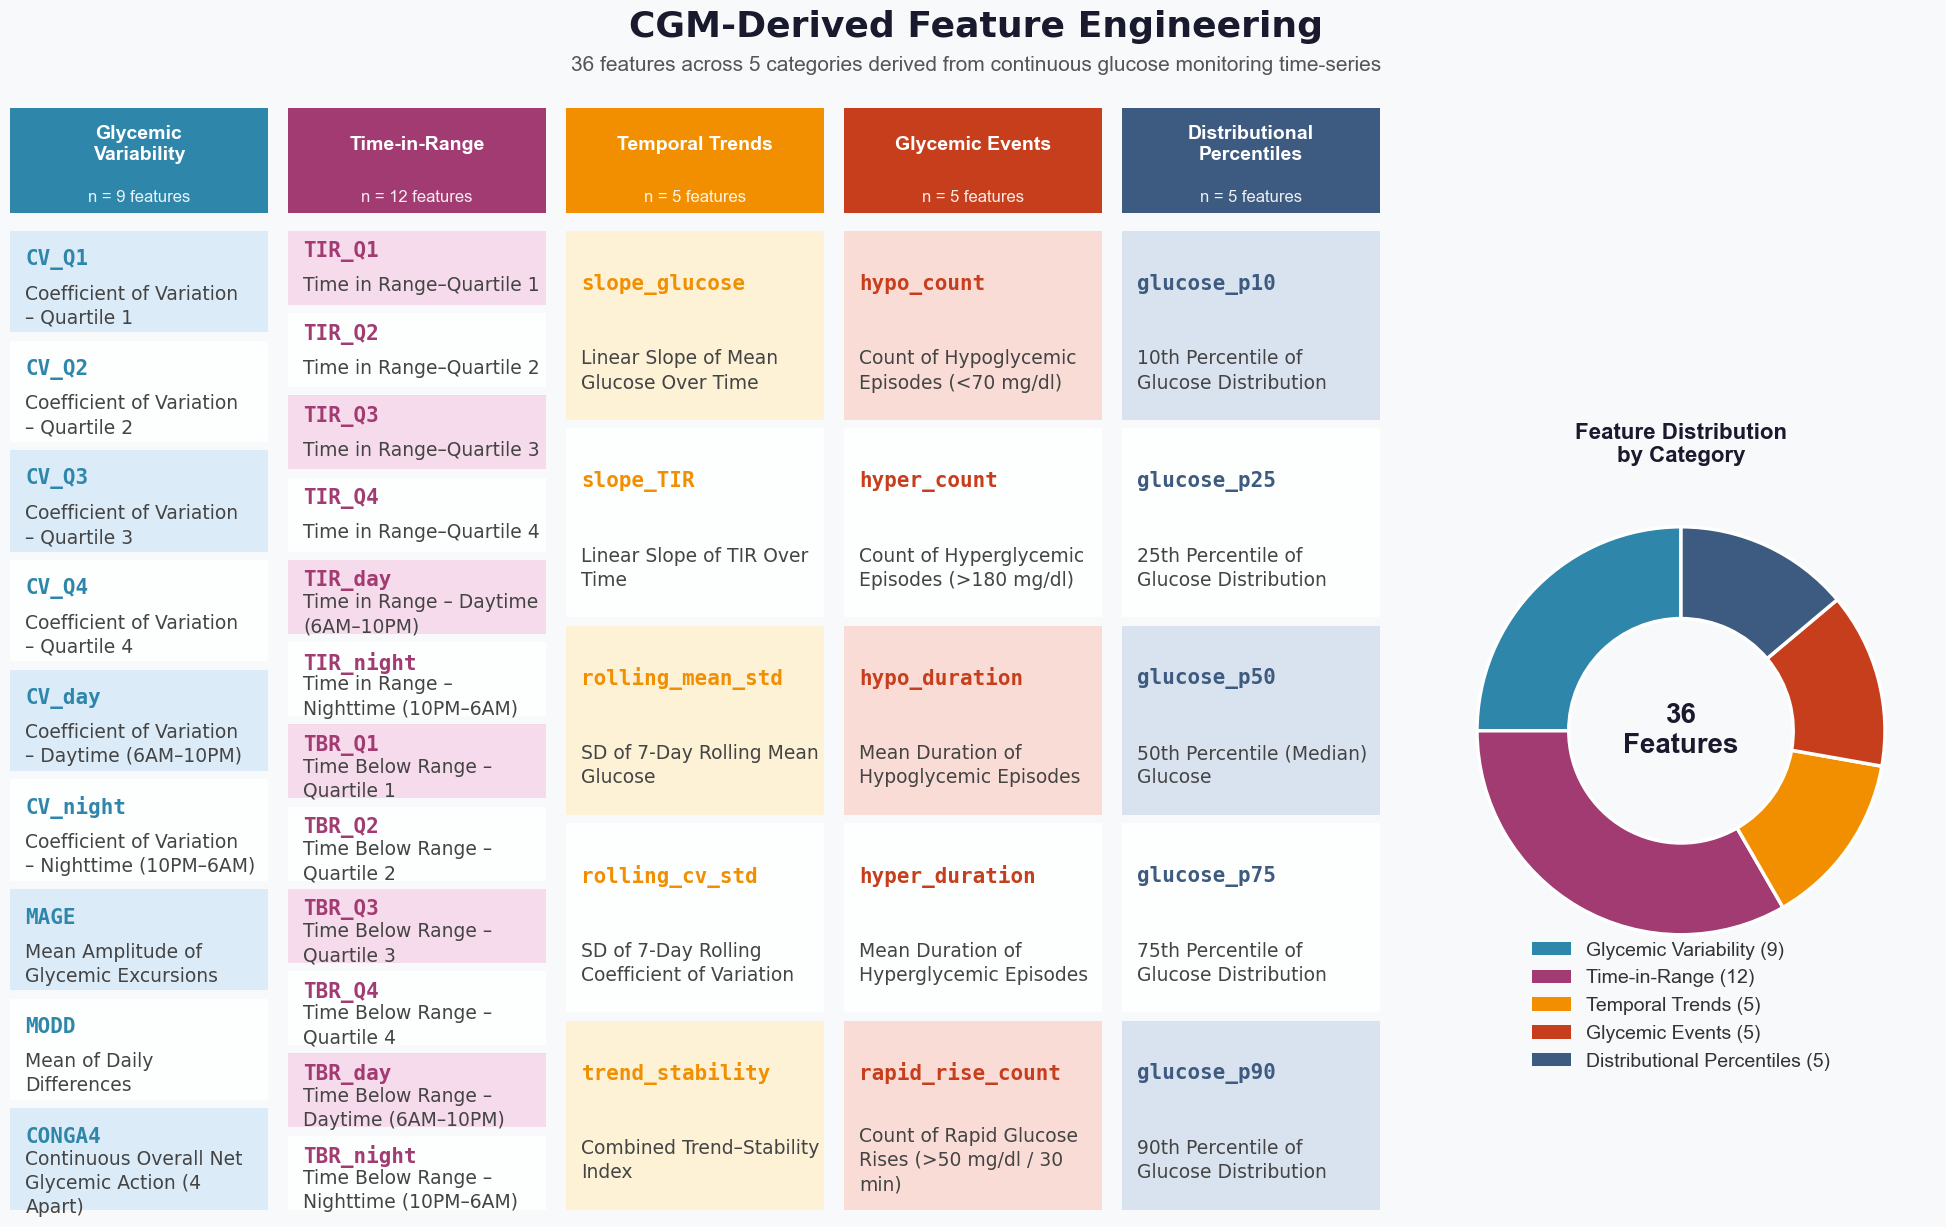

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import numpy as np
import textwrap

# ── Feature definitions ────────────────────────────────────────────────────────
categories = [
    {
        "name": "Glycemic Variability",
        "n": 9,
        "color": "#2E86AB",
        "light": "#D6EAF8",
        "icon": "CV",
        "features": [
            ("CV_Q1", "Coefficient of Variation – Quartile 1"),
            ("CV_Q2", "Coefficient of Variation – Quartile 2"),
            ("CV_Q3", "Coefficient of Variation – Quartile 3"),
            ("CV_Q4", "Coefficient of Variation – Quartile 4"),
            ("CV_day", "Coefficient of Variation – Daytime (6AM–10PM)"),
            ("CV_night", "Coefficient of Variation – Nighttime (10PM–6AM)"),
            ("MAGE", "Mean Amplitude of Glycemic Excursions"),
            ("MODD", "Mean of Daily Differences"),
            ("CONGA4", "Continuous Overall Net Glycemic Action (4 Apart)"),
        ],
    },
    {
        "name": "Time-in-Range",
        "n": 12,
        "color": "#A23B72",
        "light": "#F5D6E9",
        "icon": "TIR",
        "features": [
            ("TIR_Q1", "Time in Range–Quartile 1"),
            ("TIR_Q2", "Time in Range–Quartile 2"),
            ("TIR_Q3", "Time in Range–Quartile 3"),
            ("TIR_Q4", "Time in Range–Quartile 4"),
            ("TIR_day", "Time in Range – Daytime (6AM–10PM)"),
            ("TIR_night", "Time in Range – Nighttime (10PM–6AM)"),
            ("TBR_Q1", "Time Below Range – Quartile 1"),
            ("TBR_Q2", "Time Below Range – Quartile 2"),
            ("TBR_Q3", "Time Below Range – Quartile 3"),
            ("TBR_Q4", "Time Below Range – Quartile 4"),
            ("TBR_day", "Time Below Range – Daytime (6AM–10PM)"),
            ("TBR_night", "Time Below Range – Nighttime (10PM–6AM)"),
        ],
    },
    {
        "name": "Temporal Trends",
        "n": 5,
        "color": "#F18F01",
        "light": "#FEF0D0",
        "icon": "↗",
        "features": [
            ("slope_glucose", "Linear Slope of Mean Glucose Over Time"),
            ("slope_TIR", "Linear Slope of TIR Over Time"),
            ("rolling_mean_std", "SD of 7-Day Rolling Mean Glucose"),
            ("rolling_cv_std", "SD of 7-Day Rolling Coefficient of Variation"),
            ("trend_stability", "Combined Trend–Stability Index"),
        ],
    },
    {
        "name": "Glycemic Events",
        "n": 5,
        "color": "#C73E1D",
        "light": "#FAD7D0",
        "icon": "⚡",
        "features": [
            ("hypo_count", "Count of Hypoglycemic Episodes (<70 mg/dl)"),
            ("hyper_count", "Count of Hyperglycemic Episodes (>180 mg/dl)"),
            ("hypo_duration", "Mean Duration of Hypoglycemic Episodes"),
            ("hyper_duration", "Mean Duration of Hyperglycemic Episodes"),
            ("rapid_rise_count", "Count of Rapid Glucose Rises (>50 mg/dl / 30 min)"),
        ],
    },
    {
        "name": "Distributional Percentiles",
        "n": 5,
        "color": "#3D5A80",
        "light": "#D4E0EE",
        "icon": "%",
        "features": [
            ("glucose_p10", "10th Percentile of Glucose Distribution"),
            ("glucose_p25", "25th Percentile of Glucose Distribution"),
            ("glucose_p50", "50th Percentile (Median) Glucose"),
            ("glucose_p75", "75th Percentile of Glucose Distribution"),
            ("glucose_p90", "90th Percentile of Glucose Distribution"),
        ],
    },
]

# ── Figure layout ──────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(20, 14), facecolor="#F8F9FA")
fig.patch.set_facecolor("#F8F9FA")

# Tighter margins: content fills more of the figure
left_margin  = 0.012
panel_width  = 0.695
panel_height = 0.80
top_margin   = 0.115

# Title
fig.text(
    0.5, 0.975,
    "CGM-Derived Feature Engineering",
    ha="center", va="top",
    fontsize=26, fontweight="bold", color="#1a1a2e",
    fontfamily="DejaVu Sans",
)
fig.text(
    0.5, 0.942,
    "36 features across 5 categories derived from continuous glucose monitoring time-series",
    ha="center", va="top",
    fontsize=15, color="#555555",
)

# Summary donut chart on the right
ax_donut = fig.add_axes([0.725, 0.06, 0.255, 0.80])
ax_donut.set_aspect("equal")
sizes  = [cat["n"] for cat in categories]
colors = [cat["color"] for cat in categories]
wedges, _ = ax_donut.pie(
    sizes,
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.45, edgecolor="white", linewidth=2.5),
)
ax_donut.text(0, 0, "36\nFeatures", ha="center", va="center",
              fontsize=20, fontweight="bold", color="#1a1a2e")

legend_elements = [
    mpatches.Patch(facecolor=cat["color"], label=f"{cat['name']} ({cat['n']})")
    for cat in categories
]
ax_donut.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.20),
    ncol=1,
    frameon=False,
    fontsize=14,
    labelcolor="#333333",
)
ax_donut.set_title("Feature Distribution\nby Category", fontsize=16,
                   fontweight="bold", color="#1a1a2e", pad=10)

# ── Feature cards ──────────────────────────────────────────────────────────────
n_cols    = 5
col_width = panel_width / n_cols

for col_idx, cat in enumerate(categories):
    x0         = left_margin + col_idx * col_width
    col_height = panel_height

    # Header box
    header_ax = fig.add_axes([x0 + 0.005, top_margin + col_height - 0.085,
                               col_width - 0.010, 0.075])
    header_ax.set_xlim(0, 1)
    header_ax.set_ylim(0, 1)
    header_ax.axis("off")

    header_bg = FancyBboxPatch((0, 0), 1, 1,
                               boxstyle="round,pad=0.02",
                               facecolor=cat["color"], edgecolor="none")
    header_ax.add_patch(header_bg)

    wrapped_name = "\n".join(__import__('textwrap').wrap(cat["name"], width=16))
    header_ax.text(0.5, 0.65, wrapped_name,
                   ha="center", va="center",
                   fontsize=14, fontweight="bold", color="white",
                   linespacing=1.2)
    header_ax.text(0.5, 0.15, f"n = {cat['n']} features",
                   ha="center", va="center",
                   fontsize=12, color="white", alpha=0.9)

    # Feature rows
    n_feats          = len(cat["features"])
    feat_area_height = col_height - 0.095
    row_height       = feat_area_height / max(n_feats, 1)

    for row_idx, (short, long_desc) in enumerate(cat["features"]):
        y0 = top_margin + col_height - 0.095 - (row_idx + 1) * row_height

        feat_ax = fig.add_axes([x0 + 0.005, y0 + 0.003,
                                 col_width - 0.010, row_height - 0.006])
        feat_ax.set_xlim(0, 1)
        feat_ax.set_ylim(0, 1)
        feat_ax.axis("off")

        bg_color = cat["light"] if row_idx % 2 == 0 else "white"
        feat_bg = FancyBboxPatch((0, 0), 1, 1,
                                 boxstyle="round,pad=0.01",
                                 facecolor=bg_color,
                                 edgecolor=cat["color"], linewidth=0.4,
                                 alpha=0.85)
        feat_ax.add_patch(feat_bg)

        # Short name
        feat_ax.text(0.06, 0.72, short,
                     ha="left", va="center",
                     fontsize=15, fontweight="bold",
                     color=cat["color"],
                     fontfamily="monospace")

        # Description (wrapped)
        wrapped = "\n".join(textwrap.wrap(long_desc, width=24))
        feat_ax.text(0.06, 0.26, wrapped,
                     ha="left", va="center",
                     fontsize=13.5, color="#444444",
                     fontfamily="DejaVu Sans",
                     linespacing=1.35)

plt.show()